# Introduction

### Configuration

#### Paths

In [1]:
from pathlib import Path
# The cache directories:
cache_path       = Path('/data/crcns2021/hcpannot-cache')
image_cache_path = cache_path / 'annot-images'
v123_cache_path  = cache_path / 'annot-v123'
csulc_cache_path = cache_path / 'annot-csulc'
# The save path of the data branch:
data_path = Path('/data/crcns2021/results/data_branch/save')
# The processing path and subpaths:
proc_path    = Path('/data/crcns2021/results/proc')
traces_path  = proc_path / 'traces'
paths_path   = proc_path / 'paths'
means_path   = proc_path / 'means'
labels_path  = proc_path / 'labels'
reports_path = proc_path / 'reports'

# The file of visual surface areas for the ventral data.
ventral_sarea_path = proc_path / 'ventral_sareas.tsv'

# The hcpannot library path; if hcpannot is not on the path for
# this notebook, the notebook will try to figure out where it is
# and will use this directory as a backup.
hcpannot_lib_path = Path('~/code/hcp-annot-vc_analysis')

# If you aren't using /data
import os
os.environ['HCPANNOT_LOAD_PATH'] = os.fspath(cache_path)

#### Annotation Meta-data

In [2]:
# The sets of raters we use.
ventral_raters = [
    'BrendaQiu',
    'bogengsong',
    'JiyeongHa',
    'lindazelinzhao',
    'nourahboujaber',
    'jennifertepan']
region_raters = {
    'ventral': ventral_raters}

# The visual areas included in each pipeline/region.
region_areas = {
    'early': ('V1', 'V2', 'V3'),
    'ventral': ('hV4', 'VO1', 'VO2'),
    'dorsal': ('V3a', 'V3b', 'IPS0', 'LO1')}

# The hemispheres we are processing over.
hemis = ['lh', 'rh']

### Dependencies

In [3]:
import os, sys, pimms, pandas, json
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipyvolume as ipv
import torch
import neuropythy as ny

In [4]:
%matplotlib inline

In [5]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*2
mpl.rcParams['savefig.dpi'] = 72*4

#### Import `hcpannot`

In [6]:
# Make sure we can find the hcpannot library. If we were given a path for the
# hcpannot library, we add it to the system path here.
if hcpannot_lib_path:
    hlp = os.path.expandvars(os.fspath(hcpannot_lib_path))
    hlp = os.path.expanduser(hlp)
    if hlp.strip('/').endswith('hcpannot'):
        warnings.warn(
            "adding hcpannot_lib_path that ends with 'hcpannot';"
            " the hcpannot_lib_path should contain the hcpannot directory")
    if os.path.isdir(hlp):
        sys.path.append(hlp)
    else:
        raise ValueError("hcpannot_lib_path is not a directory")
# We try importing it and if we fail, we check to see if we are just running
# the notebook from the work directory and try again.
try:
    import hcpannot
except ModuleNotFoundError:
    hcpannot = None
    if os.getcwd().endswith('/work'):
        hlp = os.path.abspath('..')
        sys.path.append(hlp)
        
# Now we can import the hcp-annot-vc library. (It may have been imported
# above in the try block, but that's fine!)
import hcpannot

# Note the cache path we want to use outside the docker container;
# normally this gets set by the Docker startup, so here outside
# the docker container we set it manually.
hcpannot.interface.default_load_path = str(cache_path)
# We have to update some data after setting this.

# Subject lists. These are defined in the analysis subpackage of
# the hcpannot library, and subject_list_<x> is the <x>th list of
# subject IDs that we assigned.
from hcpannot.config import (
    subject_list,
    subject_list_1,
    subject_list_2,
    subject_list_3)
# The subject IDs we are processing over, as a numpy array.
sids = np.array(subject_list)

# The mean rater's name ('mean') and some plotting functions are also defined in
# the hcpannot.analysis subpackage.
from hcpannot.analysis import plot_contours

# Finally, the proc and meanproc functions, which give us the processed data.
from hcpannot.proc import proc, meanproc

### Utility Functions

These functions load the surface area reports from the processed data directories (from `reports_path`, which is a subpath of `proc_path`).

In [7]:
def load_report(region, rater, sid, h):
    """Loads surface area report for the region, rater, sid, and hemisphere.
    
    The region should be the name of one of the contour regions, e.g.
    `'ventral'`. Loads a dictionary of the processing report for the given
    rater, subject, and hemisphere, and returns a processed version of that
    report. The processing includes both square-mm and percentage reports of the
    surface area.
    
    If the file for the report is not found, it is skipped and the values are
    left as NaN.
    """
    from json import load
    data = {
        'rater':rater,
        'sid':sid,
        'hemisphere':h}
    for k in region_areas[region]:
        data[f'{k}_mm2'] = np.nan
        data[f'{k}_percent'] = np.nan
    try:
        path = os.path.join(reports_path, rater, str(sid))
        flnm = os.path.join(path, f'{h}.{region}_sareas.json')
        with open(flnm, 'rt') as fl:
            sarea = load(fl)
        for (k,v) in sarea.items():
            data[f'{k}_mm2'] = v
            if k != 'cortex':
                data[f'{k}_percent'] = v * 100 / sarea['cortex']
    except Exception as e:
        pass
    return data
def load_allreports(region, include_mean=True, sids=subject_list):
    """Loads all reports for a region and returns a dataframe of them.
    
    This runs `load_report` over all raters, subjects, and hemispheres and
    returns a dataframe of all the reports. If a report file is not found,
    then the row is left with NaNs indicating missing data.
    """
    if include_mean:
        if include_mean == True:
            include_mean = 'mean'
        include_mean = [include_mean]
    else:
        include_mean = []
    raters = (region_raters[region] + include_mean)
    return pandas.DataFrame(
        [load_report(region, rater, sid, h)
         for rater in raters
         for sid in sids
         for h in ('lh', 'rh')])
def nestget(d, k):
    """Retrieves nested data from the proc dictionaries.
    
    Certain keys such as `'boundaries'` are accessible in the dictionaries that
    are returned by the `proc` function only via the `'nested_data'` key, which
    typically contains another proc dictionary with additional data. The
    `nestget` function gets data from these embedded dictionaries.
    """
    while k not in d:
        d = d['nested_data']
    return d[k]

This function loads the logs of error messages (if any) that occurred during processing.

In [8]:
def load_proclogs(region):
    """Loads the dataframe of processing logs from the `proc_path`.
    """
    logpath = proc_path / f'proc_{region}.tsv'
    meanlogpath = proc_path / f'proc_mean{region}.tsv'
    procdf = pandas.read_csv(logpath, sep='\t', keep_default_na=False)
    meandf = pandas.read_csv(meanlogpath, sep='\t', keep_default_na=False)
    df = pandas.concat([procdf, meandf])
    return df

## Usage Notes

### How to Examine the Processed Contour Data

The `proc` function can be used to query processed data. `proc` returns a (lazy) dictionary of the processed data. If the requested data have not been previously calculated and cached, the `proc` function will do so, saving cached results to (and loading them from) the directory provided via the `save_path` option. The `load_path` refers to the directory from which the contours should be loaded, i.e. the `save` directory of the [`data` branch of the `noahbenson/hcp-annot-vc` GitHub repository](https://github.com/noahbenson/hcp-annot-vc/tree/data).

#### Examples:

* Load (or prepare to calculate) the processed ventral contour data for rater `BrendaQiu`, HCP subject `100610`, and the left hemisphere.  
  ```python
  >>> from hcpannot.proc import proc 
  >>> data = proc(
  ...     'ventral',
  ...     rater='BrendaQiu',
  ...     sid=100610,
  ...     hemisphere='lh',
  ...     save_path=proc_path,
  ...     load_path=data_path)
  ```
* View the keys of the processed data dictionary.  
  ```python
  >>> sorted(data.keys())
  ['chirality',
   'contours',
   'cortex',
   'flatmap',
   'hemisphere',
   'io_options',
   'label_weights',
   'labelkey',
   'labels',
   'nested_data',
   'paths',
   'rater',
   'region',
   'reports',
   'save_path',
   'sid',
   'traces']
  ```
* View the contours. Each contour is a `2xN` matrix of the (`x`,`y`)-values of the points clicked by the rater. The coordinates of the points are registered to the flatmap on which they were drawn, which is given by `data['flatmap']`.  
  ```python
  >>> data['contours']
  {'hV4_VO1': array([[ 38.02148285,  32.13910222, ...],
                     [-44.74639194, -46.70718548, ...]]),
   'VO1_VO2': array([[ 39.00187962,  38.02148285, ...],
                     [-44.25525238, -47.68664107, ...]]),
   'hV4_outer': array([[-18.51013327, -19.33172823, ...],
                       [-14.4353661 , -18.76493634, ...]]),
   'VO_outer': array([[ 38.80127474,  43.90386347, ...],
                      [-43.03350935, -44.74639194, ...]])}
  ```
* Plot a contour on the flatmap.  
  ```python
  >>> import neuropythy as ny, matplotlib.pyplot as plt
  >>> color = 'prf_polar_angle'
  >>> mask = ('prf_variance_explained', 0.1, 1)
  >>> (fig,ax) = plt.subplots(1,1, figsize=(8,8))
  >>> ny.cortex_plot(data['flatmap'], color=color, mask=mask, axes=ax)
  >>> (x, y) = data['contours']['hV4_outer']
  >>> ax.plot(x, y, 'wo-')
  >>> plt.show()
  ```

Here's an example code-block using the `plot_contours` function to plot a set of boundaries along with the V1-V3 contours.

```python
>>> data = proc(
...     'ventral',
...     rater='BrendaQiu',
...     sid=100610,
...     hemisphere='lh',
...     save_path=proc_path,
...     load_path=data_path)

# Make the flatmap plot and the boundaries.
>>> fig = plot_contours(dat, boundaries=True)

# Extract the pyplot axes that were used.
>>> ax = fig.axes[0]

# Grab the subject data, which includes the V1-V3 contours.
>>> sdat = hcpannot.interface.subject_data[(dat['sid'],dat['hemisphere'])]

# And plot all of these contours:
>>> for (x,y) in sdat['v123'].values():
...     ax.plot(x, y, 'w-', lw=0.25)
```

# Workspace

## Reviewing the Logs for Contour Processing

In [20]:
proclog = load_proclogs('ventral')
df = proclog
df = df[df['error'] != '']
ii = np.array([err.startswith('load_contours') for err in df['error']])
procerrors_filemissing = df[ii]
procerrors = df[~ii]

procerrors

,rater,sid,hemisphere,dt,error
40,nourahboujaber,104416,lh,0.182489,0 VO1-VO2 / Working-Outer intersections
1142,JiyeongHa,246133,lh,0.518950,3 self-intersections in polygon
2044,nourahboujaber,910241,lh,0.229584,0 VO1-VO2 / Working-Outer intersections


In [38]:
region = 'ventral'

allprocs = {
    (r,s,h): ny.util.curry(
       lambda r,s,h: proc(
           'ventral',
           rater=r, sid=s, hemisphere=h,
           load_path=data_path, save_path=proc_path,
           overwrite=False),
       r, s, h)
    for r in region_raters[region]
    for s in sids
    for h in ('lh','rh')}
for s in sids:
    for h in ('lh','rh'):
        allprocs['mean', s, h] = meanproc(
            'ventral',
            sid=s, hemisphere=h,
            load_path=data_path, save_path=proc_path,
            overwrite=False)
allprocs = pimms.lazy_map(allprocs)

## Contour Quality Control

### Look for targets with surface Areas that are outliers

In [56]:
# Load in the surface area data; we will look for outliers here.
region = 'ventral'
sareas = load_allreports(region)

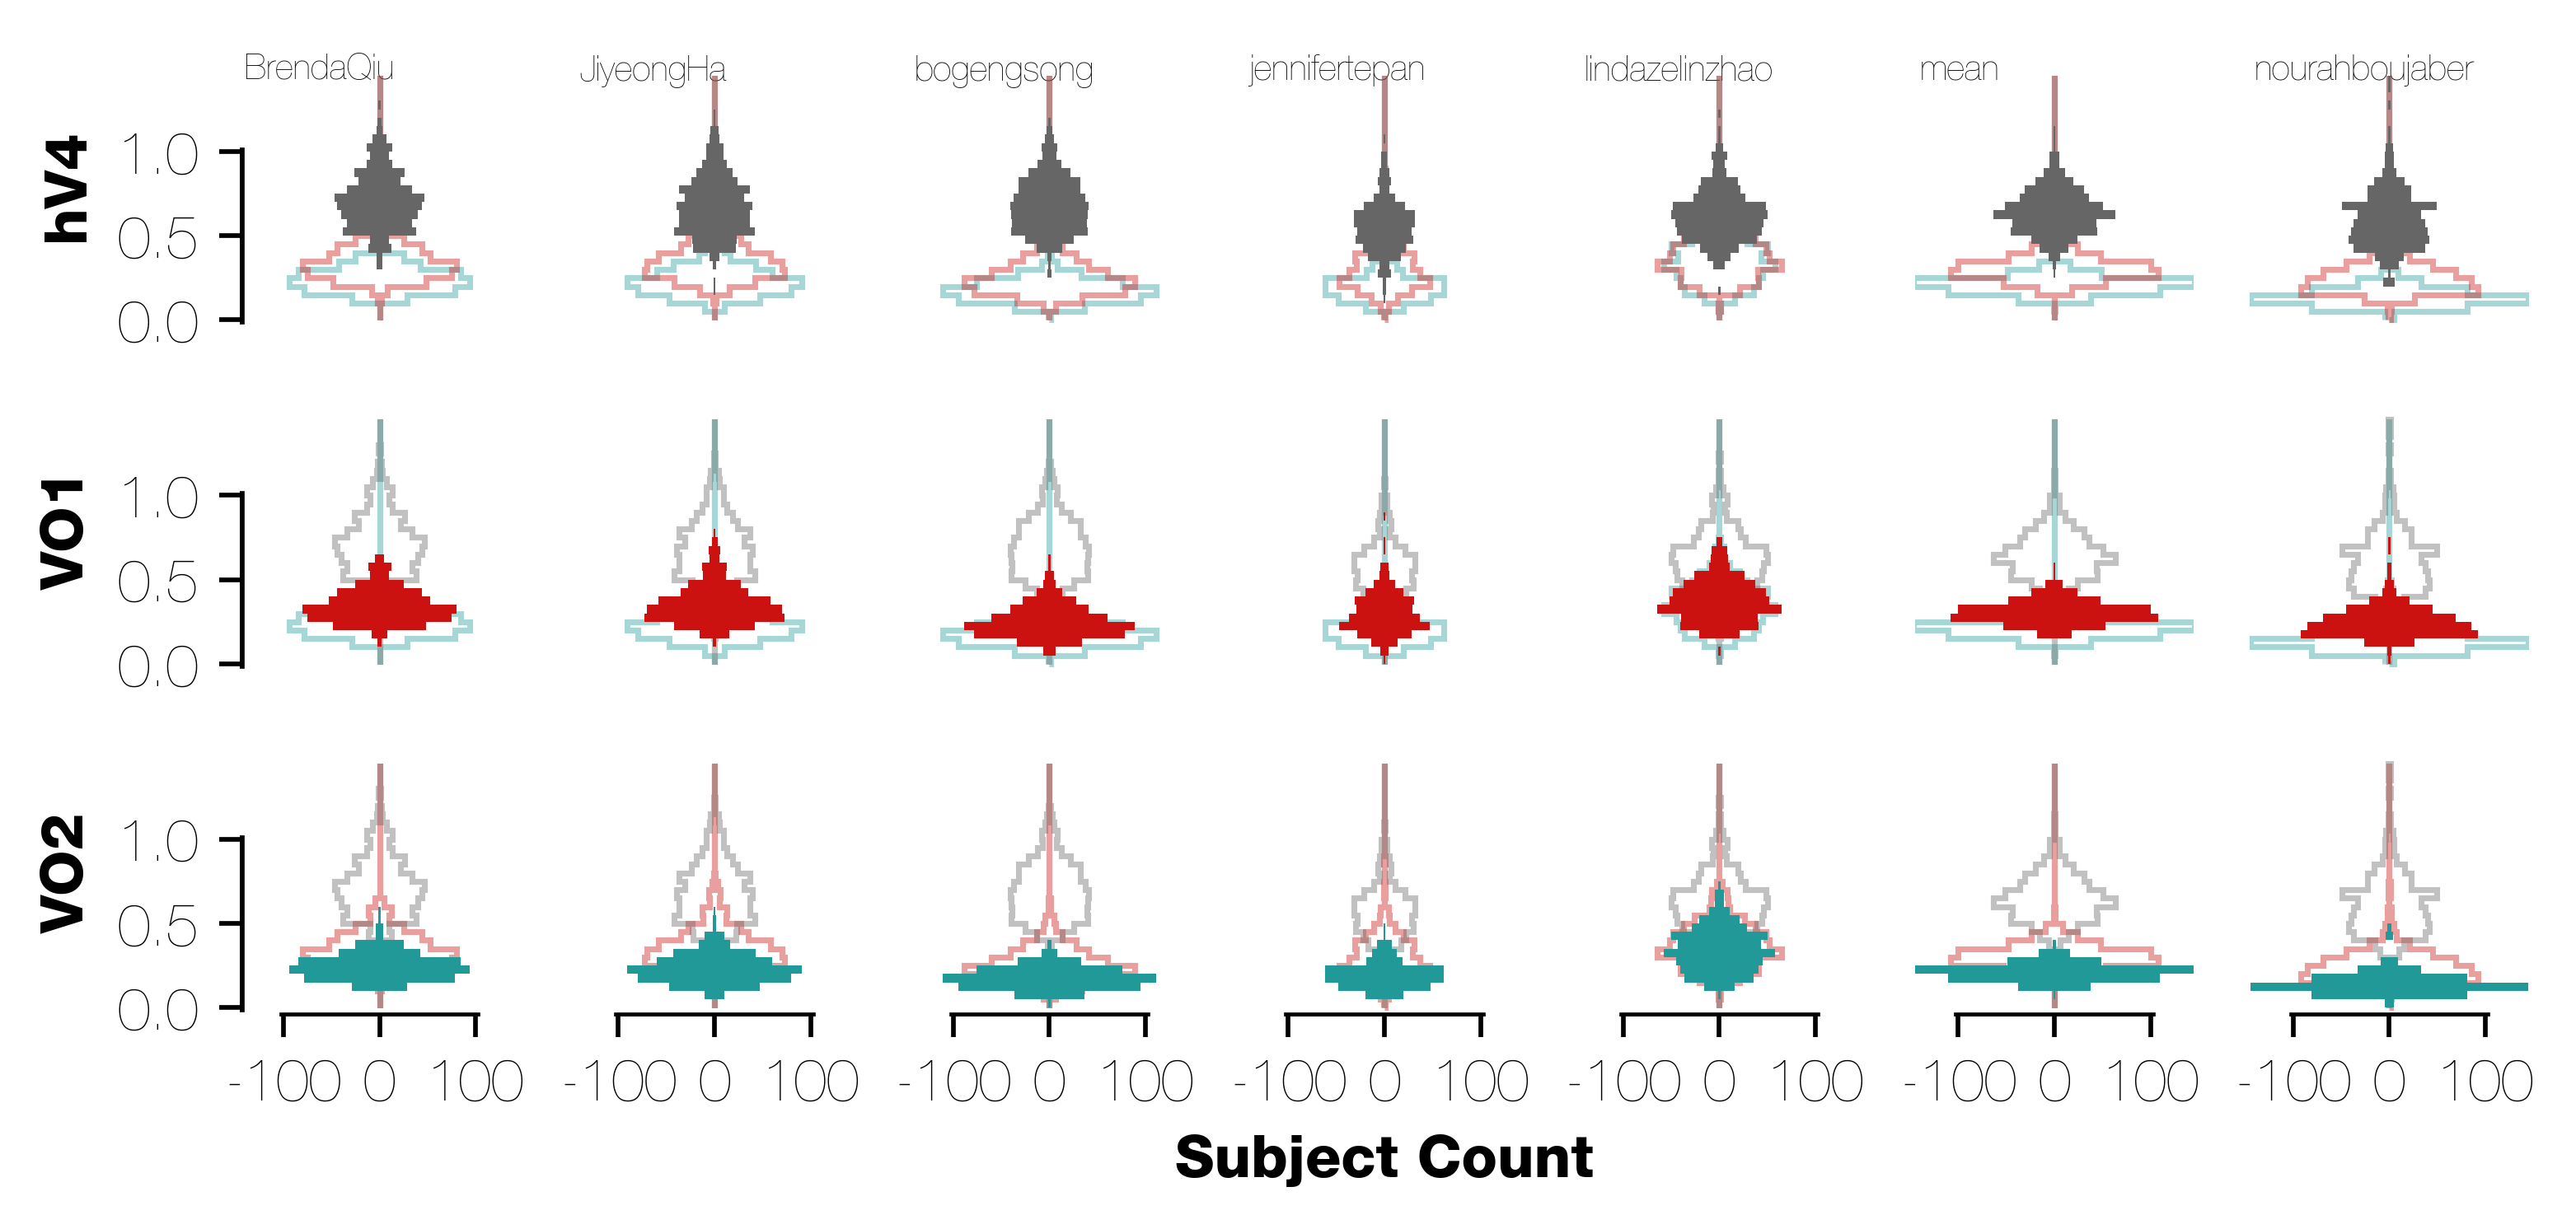

In [57]:
# We operate on the surface areas dataframe we loaded.
df = sareas

# We'll plot these visual area sizes:
plot_areas = list(region_areas[region])
plot_columns = {k: f'{k}_percent' for k in plot_areas}
plot_colors = dict(zip(plot_areas, ["#666666", "#cc1111", "#229999", "#884444"]))
plot_raters = np.unique(df['rater'].values)

# For each rater we'll make a vertical histogram with the same parameters.
(fig, axs) = plt.subplots(
    len(plot_areas), len(plot_raters),
    figsize=(len(plot_raters), len(plot_areas)),
    dpi=512)

hist_opts = {'bins': np.arange(0, 1.5, 0.05)}

for (axcol,rater) in zip(axs.T, plot_raters):
    work_df = df[df['rater'] == rater]
    for (ax,area) in zip(axcol, plot_areas):
        ax.hist(
            [work_df[plot_columns[k]] for k in plot_areas if k != area],
            label=plot_areas,
            histtype='step',
            orientation='horizontal',
            color=[plot_colors[k] + '66' for k in plot_areas if k != area],
            zorder=9,
            **hist_opts)
        ax.hist(
            work_df[plot_columns[area]],
            histtype='stepfilled',
            orientation='horizontal',
            color=plot_colors[area],
            zorder=10,
            **hist_opts)
        # We now do a trick to make the histogram polygon symmetric:
        for poly in ax.patches:
            xy = poly.xy
            rxy = xy * [-1,1]
            poly.set_xy(np.concatenate([xy, np.flipud(rxy)]))
for (area,ax) in zip(plot_areas, axs[:,0]):
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylabel(area)
    ax.plot([-145,-145], [0,1], 'k-', lw=1.5)
for ax in axs[-1,:]:
    ax.set_xticks([-100, 0, 100])
    ax.set_xticklabels(['-100', '0', '100'])
    ax.plot([-100,100], [-0.05,-0.05], 'k-', lw=1.5)
axs[-1,3].set_xlabel('Subject Count')
for (rater,ax) in zip(plot_raters, axs[0]):
    ax.text(-140, 1.425, rater, fontsize=6)
for ax in axs[:,1:].flatten():
    ax.set_yticks([])
for ax in axs[:-1,:].flatten():
    ax.set_xticks([])
for ax in axs.flatten():
    ax.set_ylim([-0.05, 1.65])
    ax.set_xlim([-145,145])
    for s in ax.spines.values():
        s.set_visible(False)

In [80]:
sareas.sort_values('hV4_percent', ascending=False).head()

,rater,sid,hemisphere,hV4_mm2,hV4_percent,VO1_mm2,VO1_percent,VO2_mm2,VO2_percent,cortex_mm2
1456,nourahboujaber,105923,lh,1517.338257,1.498033,353.872925,0.349370,294.084045,0.290342,101288.734375
1457,nourahboujaber,105923,rh,1441.603271,1.424495,273.389282,0.270145,111.782631,0.110456,101201.000000
1452,nourahboujaber,102816,lh,1229.907227,1.390605,640.753906,0.724474,353.837585,0.400070,88444.023438
1450,nourahboujaber,102311,lh,1238.508911,1.282485,452.793915,0.468872,429.259430,0.444501,96570.992188
293,BrendaQiu,751550,rh,1225.261353,1.269083,346.842102,0.359247,229.343872,0.237546,96546.953125


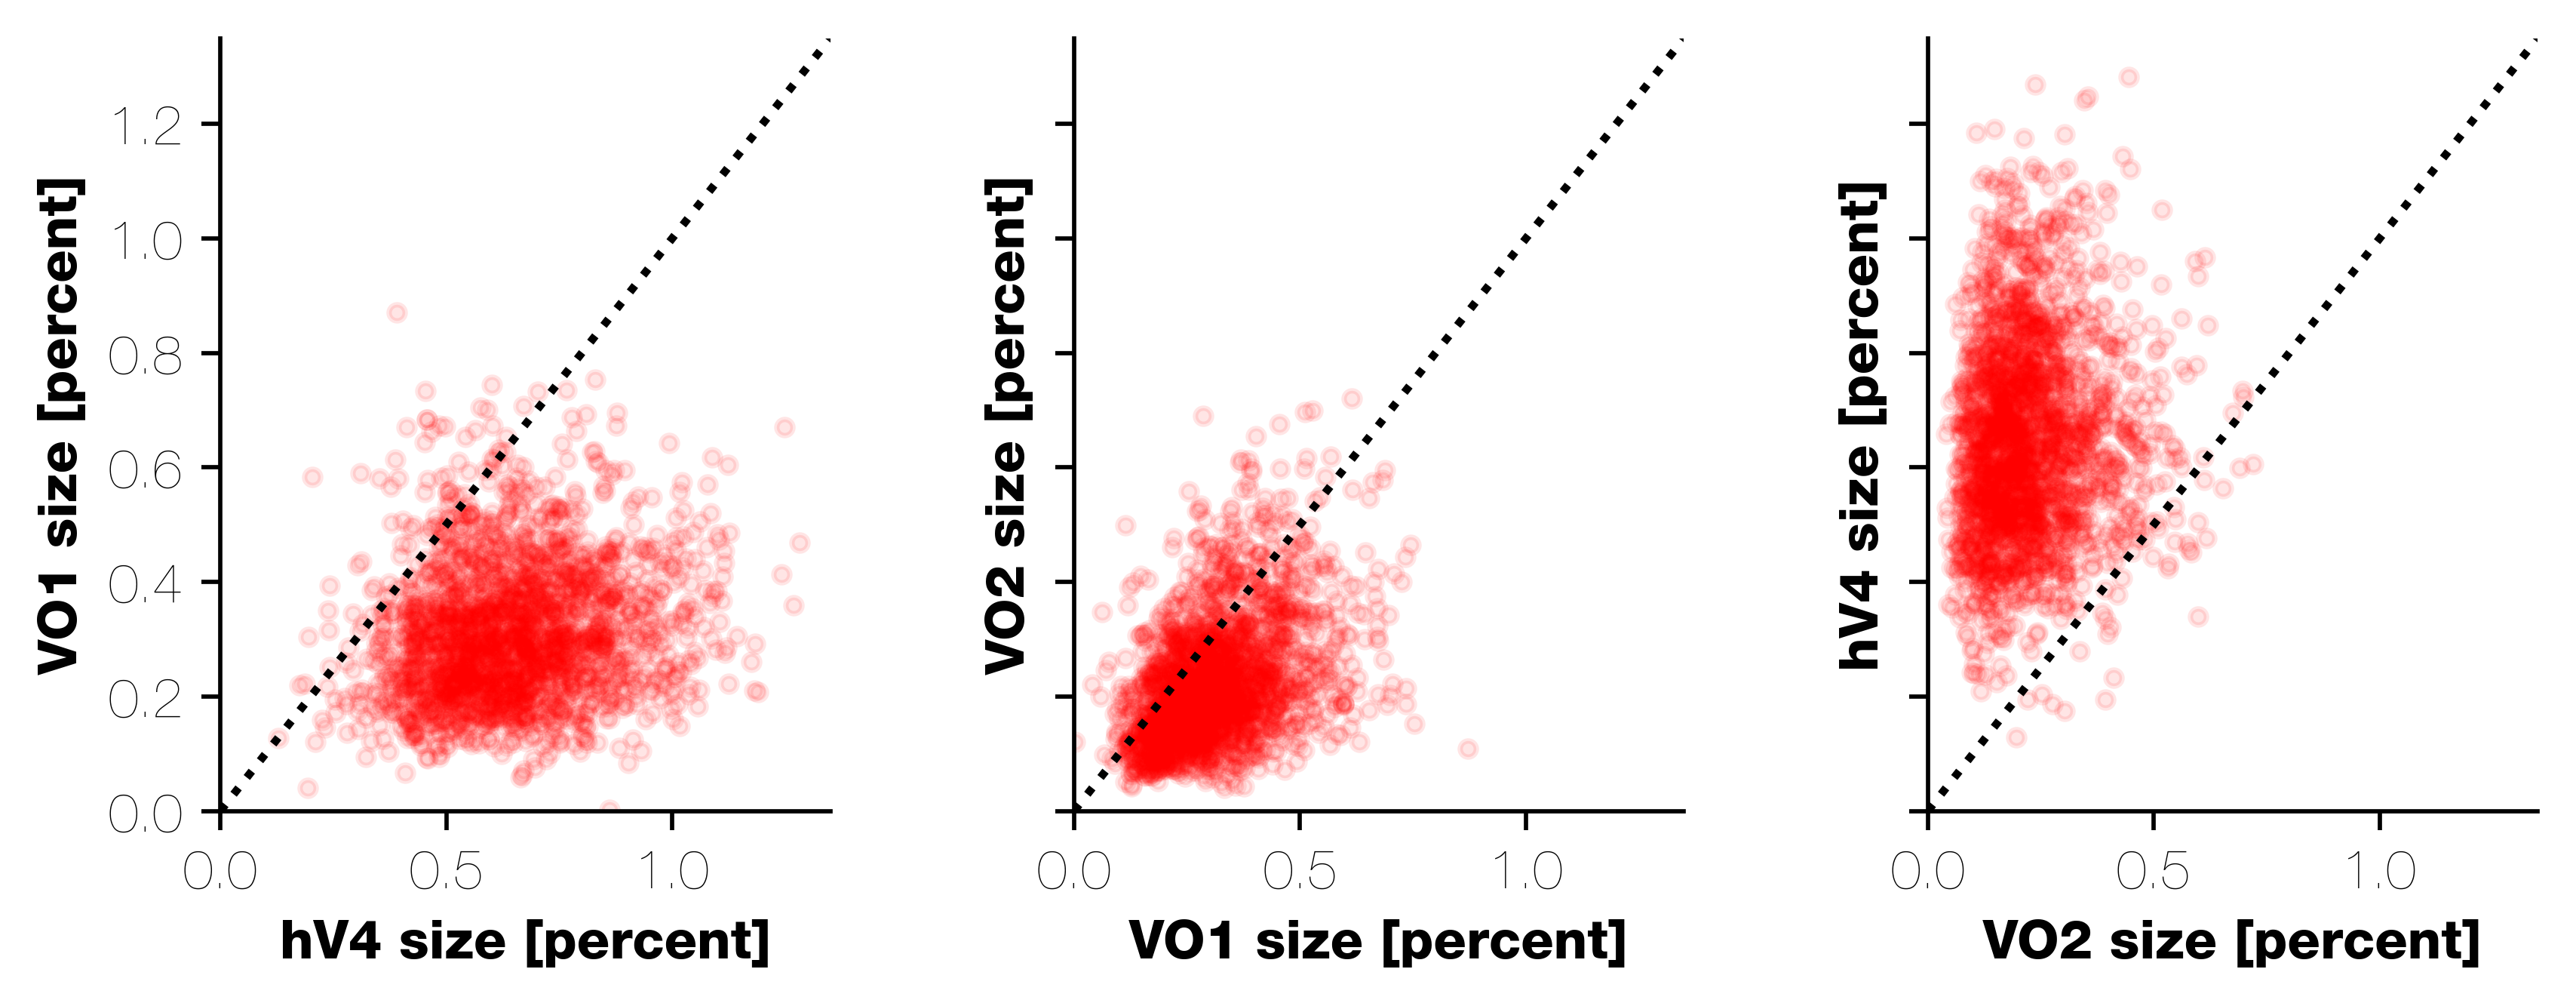

In [65]:
# We work with the currently loaded surface areas dataframe (see above).
df = sareas
work_df = df[df['rater'] != 'mean']

(fig, axs) = plt.subplots(1, 3, figsize=(6,2), dpi=512, sharex=True, sharey=True)
fig.subplots_adjust(0, 0, 1, 1, 0.4, 0)

for (ax, area1, area2) in zip(axs, ['hV4', 'VO1', 'VO2'], ['VO1', 'VO2', 'hV4']):
    sarea1 = work_df[f'{area1}_percent']
    sarea2 = work_df[f'{area2}_percent']
    ax.plot(sarea1, sarea2, 'r.', alpha=0.1)
    ax.set_xlabel(area1 + ' size [percent]')
    ax.set_ylabel(area2 + ' size [percent]')
    ax.plot([0,1.5], [0,1.5], 'k:')
    ax.set_xlim([0,1.35])
    ax.set_ylim([0,1.35])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.axis('equal')

plt.show()

### Examining a Single Set of Contours

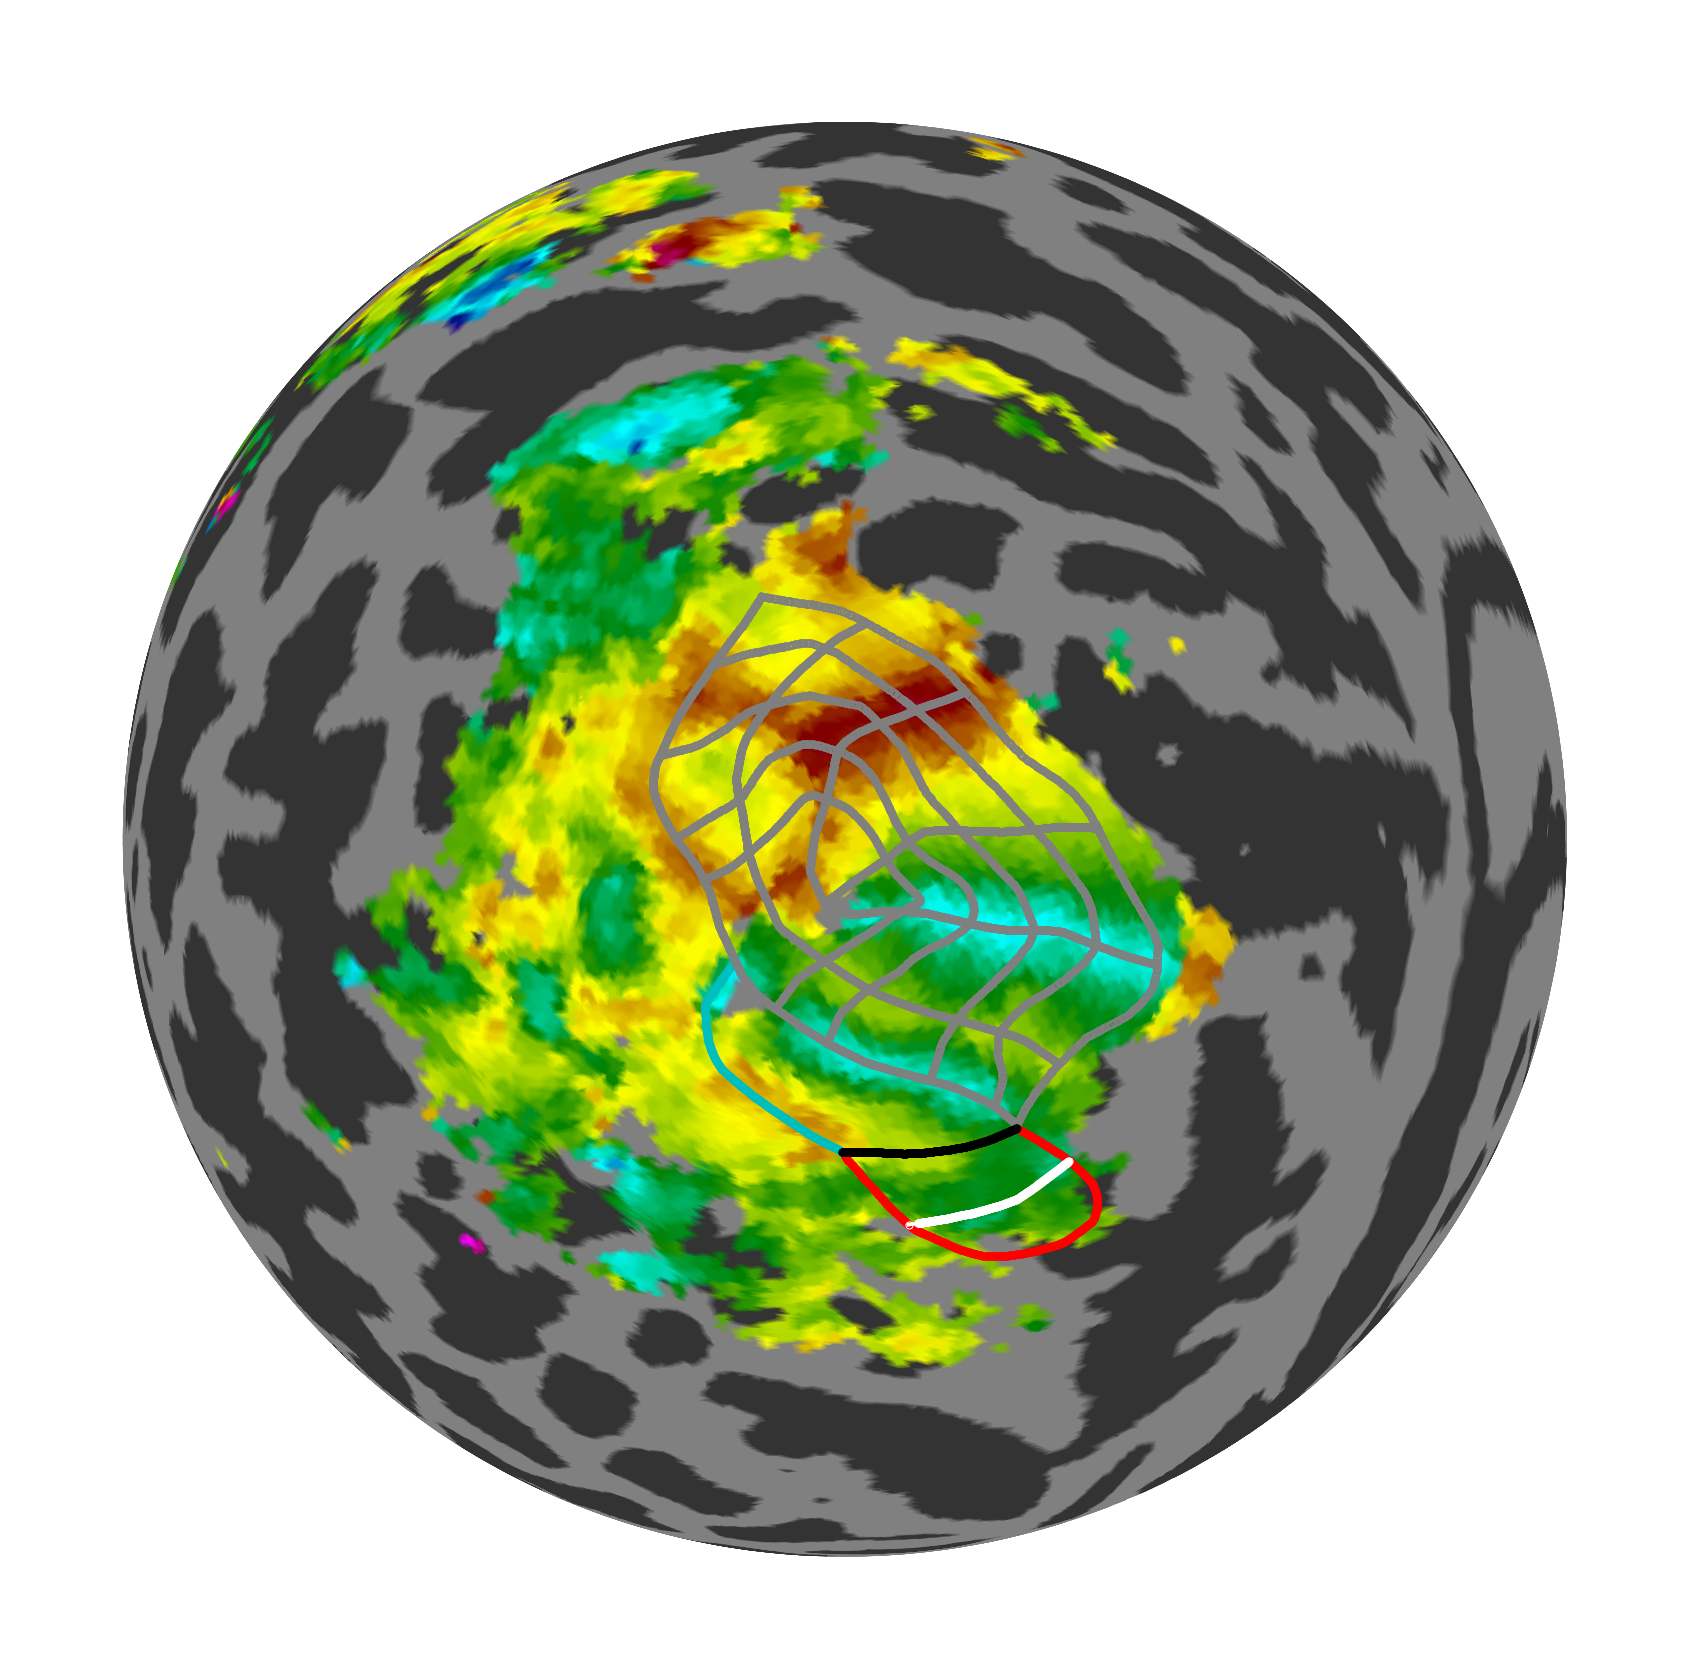

In [82]:
# Which set of contours are we going to plot?
rater = 'mean'
sid = 111312
h = 'lh'

# What we'll plot on the flatmap, and what mask we'll use:
plot_color = 'prf_polar_angle'
plot_mask = ('prf_variance_explained', 0.1, 1)

# What traces do we want to plot and what style? By putting thicker lines (lw)
# and larger markers (ms) on the bottom (lower zorder) we can see multiple
# contours that overlap.
plot_opts = dict(
    hV4_outer=dict(c='c', lw=0.5, ms=1, zorder=2),
    VO_outer=dict(c='r', lw=0.5, ms=1, zorder=2),
    hV4_VO1=dict(c='k', lw=0.5, ms=1, zorder=3),
    VO1_VO2=dict(c='w', lw=0.5, ms=1, zorder=3))

# Get the processed data.
dat = allprocs[rater, sid, h]

# Extract the flatmap and the traces.
fmap = dat['flatmap']
traces = dat['traces']

# Make a figure with one set of axes and plot the flatmap on it.
(fig,ax) = plt.subplots(1,1, figsize=(4,4), dpi=512)
ax.axis('off')
ny.cortex_plot(fmap, color=plot_color, mask=plot_mask, axes=ax)

# Plot each of the traces in the plot_opts:
for (name, opts) in plot_opts.items():
    trace = traces[name]
    (x,y) = trace.curve.coordinates
    # If we're plotting the mean, we want to reduce the marker size
    # because there are many dots instead of just a few.
    if rater == 'mean':
        opts = dict(opts, ms=0.15)
    ax.plot(x, y, 'o-', **opts)
# Plot the V1-V3 contours also:
sdat = hcpannot.interface.subject_data[(sid, h)]
for (x,y) in sdat['v123'].values():
    ax.plot(x, y, 'o', c='0.5', ms=0.15)

plt.show()